In [170]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [171]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [172]:
query = """select *
        from eigensonne_dwh.public.lead_scoring_sample_1 """
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,lead_campaign,bundesland,closest_team,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
0,00Q5J000002qx3WUAQ,Website,None,None,Schleswig-Holstein,hotel,35,24,Regular,1,0,0,14,1
1,00Q5J000002qx7dUAA,Wattfox,affiliate,wattfox-standard,Bayern,echo,35,18,Regular,1,0,0,8,0
2,00Q5J000002qx7jUAA,Wattfox,affiliate,wattfox-standard,Baden-Württemberg,india,35,31,Regular,1,0,0,18,1
3,00Q5J000002qx7JUAQ,Wattfox,affiliate,wattfox-standard,Bayern,echo,75,53,Regular,1,0,0,14,1
4,00Q5J000002qx7TUAQ,Wattfox,affiliate,wattfox-standard,Nordrhein-Westfalen,juliett,35,18,Regular,1,0,0,14,1


In [173]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [174]:
print(base.shape)
base.dtypes

(13917, 14)


id                           object
lead_source                  object
lead_medium                  object
lead_campaign                object
bundesland                   object
closest_team                 object
radius_category              object
distance                      int64
record_type_name_c           object
has_opened                    int64
has_clicked_non_photo_url     int64
photo_upload                  int64
duration_photo_upload         int64
has_reached_wfp               int64
dtype: object

In [175]:
#drop data closest team and radius category cause of duplocates
base=base.drop(['closest_team','radius_category'],1)

In [176]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13917 entries, 0 to 13916
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         13917 non-null  object
 1   lead_source                13643 non-null  object
 2   lead_medium                13188 non-null  object
 3   lead_campaign              12941 non-null  object
 4   bundesland                 13917 non-null  object
 5   distance                   13917 non-null  int64 
 6   record_type_name_c         13917 non-null  object
 7   has_opened                 13917 non-null  int64 
 8   has_clicked_non_photo_url  13917 non-null  int64 
 9   photo_upload               13917 non-null  int64 
 10  duration_photo_upload      13917 non-null  int64 
 11  has_reached_wfp            13917 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.3+ MB


In [177]:
base.describe()

,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
count,13917.000000,13917.000000,13917.000000,13917.000000,13917.000000,13917.000000
mean,43.723432,0.677660,0.074872,0.072789,7.323274,0.254006
std,30.009559,0.467389,0.263195,0.259799,9.655062,0.435317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,1.000000,0.000000,0.000000,2.000000,0.000000
75%,60.000000,1.000000,0.000000,0.000000,14.000000,1.000000
max,279.000000,1.000000,1.000000,1.000000,101.000000,1.000000


In [178]:
base.isnull().sum()

id                             0
lead_source                  274
lead_medium                  729
lead_campaign                976
bundesland                     0
distance                       0
record_type_name_c             0
has_opened                     0
has_clicked_non_photo_url      0
photo_upload                   0
duration_photo_upload          0
has_reached_wfp                0
dtype: int64

In [179]:
#see percentage of null values to drop the once >= 70%

round(100*(base.isnull().sum()/len(base.index)), 2)

id                           0.00
lead_source                  1.97
lead_medium                  5.24
lead_campaign                7.01
bundesland                   0.00
distance                     0.00
record_type_name_c           0.00
has_opened                   0.00
has_clicked_non_photo_url    0.00
photo_upload                 0.00
duration_photo_upload        0.00
has_reached_wfp              0.00
dtype: float64

In [180]:
# we will drop the columns having more than 70% NA values.
data = base.drop(base.loc[:,list(round(100*(base.isnull().sum()/len(base.index)), 2)>70)].columns, 1)

In [181]:
# Now we will take care of null values in each column one by one.
data['lead_source'].describe()

count       13643
unique         26
top       Wattfox
freq         4794
Name: lead_source, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

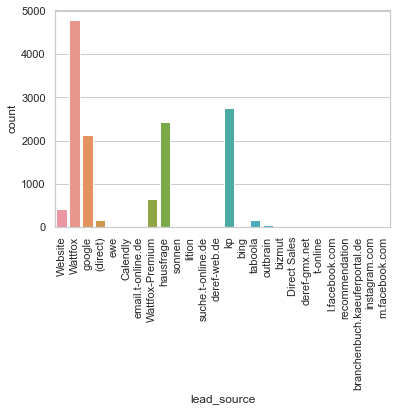

In [182]:
sns.countplot(data['lead_source'])
xticks(rotation = 90)

In [183]:
data.groupby(['lead_source'])['id'].count()

lead_source
(direct)                          166
Calendly                           28
Direct Sales                        2
Wattfox                          4794
Wattfox-Premium                   651
Website                           424
bing                                1
bizmut                              1
branchenbuch.kaeuferportal.de       1
deref-gmx.net                       1
deref-web.de                        1
email.t-online.de                   3
ewe                                 1
google                           2126
hausfrage                        2430
instagram.com                       1
kp                               2757
l.facebook.com                      1
lition                             23
m.facebook.com                      1
outbrain                           51
recommendation                      4
sonnen                             18
suche.t-online.de                   1
t-online                            1
taboola                           155


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

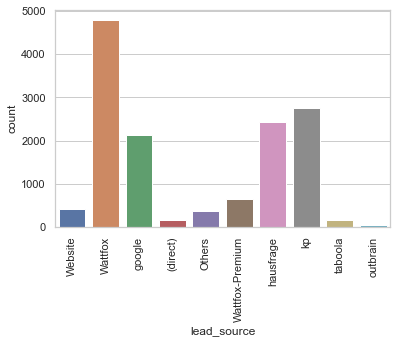

In [184]:
#taking into account that we always knows when leads come from affiliates, we will call the null values and 
#every lead comming from a source with a total of leads < 30 'Other'
data['lead_source'] = data['lead_source'].replace(np.nan, 'Others')
data['lead_source'] = data['lead_source'].replace(data.loc[data.groupby('lead_source').lead_source.transform('count').lt(30),
                               'lead_source'],'Others')

sns.countplot(data['lead_source'])
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

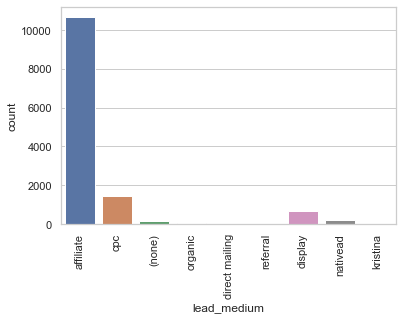

In [185]:
sns.countplot(data['lead_medium'])
xticks(rotation = 90)

In [186]:
data.groupby(['lead_medium'])['id'].count()

lead_medium
(none)              166
affiliate         10673
cpc                1424
direct mailing        1
display             651
kristina              1
nativead            206
organic              52
referral             14
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

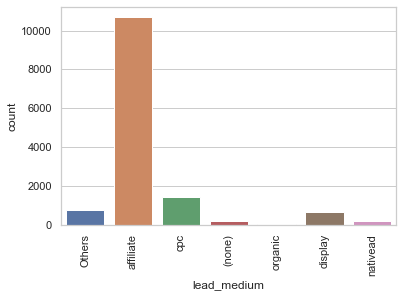

In [187]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a medium with a total of leads < 30 'Others'
data['lead_medium'] = data['lead_medium'].replace(np.nan, 'Others')
data['lead_medium'] = data['lead_medium'].replace(data.loc[data.groupby('lead_medium').lead_medium.transform('count').lt(30),
                               'lead_medium'],'Others')

sns.countplot(data['lead_medium'])
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75]),
 <a list of 76 Text major ticklabel objects>)

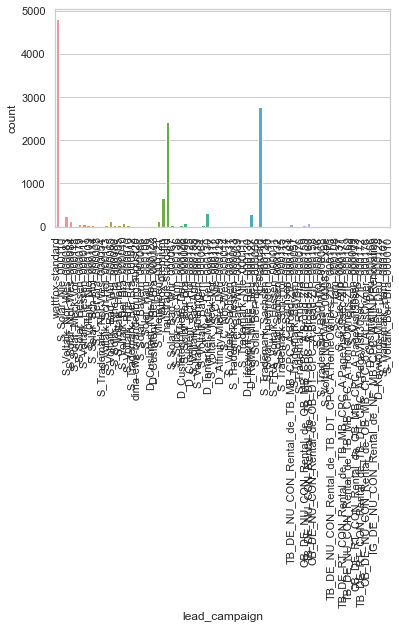

In [188]:
#there are too many different categories that variate too much among each other so this is not reliable
sns.countplot(data['lead_campaign'])
xticks(rotation = 90)

In [189]:
data = data.drop(['lead_campaign'],1)

In [190]:
data['record_type_name_c'].describe()


count       13917
unique          2
top       Regular
freq        11244
Name: record_type_name_c, dtype: object

In [191]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                           0.0
lead_source                  0.0
lead_medium                  0.0
bundesland                   0.0
distance                     0.0
record_type_name_c           0.0
has_opened                   0.0
has_clicked_non_photo_url    0.0
photo_upload                 0.0
duration_photo_upload        0.0
has_reached_wfp              0.0
dtype: float64

In [192]:
#Exploratory Data Analytics
# Univariate Analysis 

In [193]:
Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

7.278867572034203

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

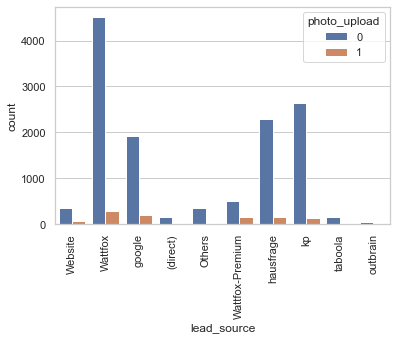

In [194]:
#lead_source 
sns.countplot(x = "lead_source", hue = "photo_upload", data = data)
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

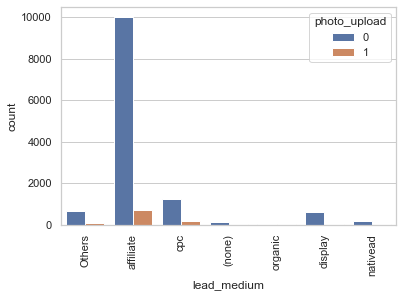

In [195]:
#lead_source 
sns.countplot(x = "lead_medium", hue = "photo_upload", data = data)
xticks(rotation = 90)

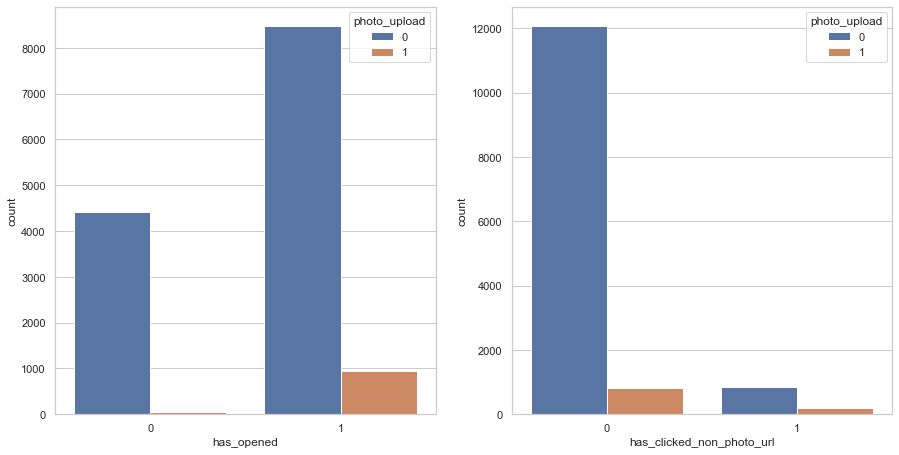

In [196]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_upload", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_upload", data = data, ax = axs[1])

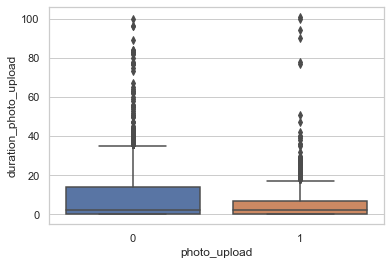

In [197]:
sns.boxplot(y = 'duration_photo_upload', x = 'photo_upload', data = data)

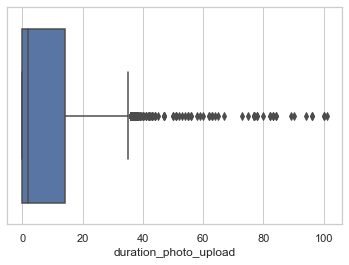

In [198]:
sns.boxplot(data['duration_photo_upload'])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

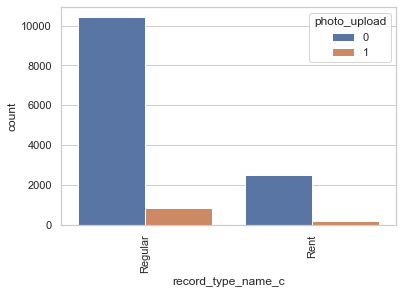

In [199]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_upload", data = data)
xticks(rotation = 90)

In [200]:
data.head(10)

,id,lead_source,lead_medium,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
0,00Q5J000002qx3WUAQ,Website,Others,Schleswig-Holstein,24,Regular,1,0,0,14,1
1,00Q5J000002qx7dUAA,Wattfox,affiliate,Bayern,18,Regular,1,0,0,8,0
2,00Q5J000002qx7jUAA,Wattfox,affiliate,Baden-Württemberg,31,Regular,1,0,0,18,1
3,00Q5J000002qx7JUAQ,Wattfox,affiliate,Bayern,53,Regular,1,0,0,14,1
4,00Q5J000002qx7TUAQ,Wattfox,affiliate,Nordrhein-Westfalen,18,Regular,1,0,0,14,1
5,00Q5J000002qx7xUAA,Wattfox,affiliate,Berlin,14,Regular,0,0,0,40,0
6,00Q5J000002qx8bUAA,Wattfox,affiliate,Hessen,60,Regular,0,0,0,8,0
7,00Q5J000002qx8lUAA,Wattfox,affiliate,Nordrhein-Westfalen,30,Regular,1,0,0,15,1
8,00Q5J000002qx9UUAQ,Wattfox,affiliate,Hessen,13,Regular,1,0,0,14,1
9,00Q5J000002qxaQUAQ,Wattfox,affiliate,Nordrhein-Westfalen,29,Rent,1,0,0,19,0


In [201]:
# Data Preparation



In [202]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
                           'lead_medium','bundesland']], drop_first=True)

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [203]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_source,lead_medium,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,00Q5J000002qx3WUAQ,Website,Others,Schleswig-Holstein,24,Regular,1,0,0,14,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000002qx7dUAA,Wattfox,affiliate,Bayern,18,Regular,1,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000002qx7jUAA,Wattfox,affiliate,Baden-Württemberg,31,Regular,1,0,0,18,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000002qx7JUAQ,Wattfox,affiliate,Bayern,53,Regular,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000002qx7TUAQ,Wattfox,affiliate,Nordrhein-Westfalen,18,Regular,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [204]:
data = data.drop(['lead_source', 'lead_medium',	'bundesland',
                             'record_type_name_c'], axis = 1)


In [205]:
data.head(10)

,id,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,00Q5J000002qx3WUAQ,24,1,0,0,14,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000002qx7dUAA,18,1,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000002qx7jUAA,31,1,0,0,18,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000002qx7JUAQ,53,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000002qx7TUAQ,18,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00Q5J000002qx7xUAA,14,0,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,00Q5J000002qx8bUAA,60,0,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,00Q5J000002qx8lUAA,30,1,0,0,15,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,00Q5J000002qx9UUAQ,13,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,00Q5J000002qxaQUAQ,29,1,0,0,19,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [206]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_upload'], axis=1)
X.head()

,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,24,1,0,14,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,18,1,0,8,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31,1,0,18,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,53,1,0,14,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,1,0,14,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [207]:
y = data['photo_upload']

y.head()

0    0
1    0
2    0
3    0
4    0
Name: photo_upload, dtype: int64

In [208]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=None)

In [209]:
#feature scaling
scaler = StandardScaler()

X_train[['distance','duration_photo_upload']] = scaler.fit_transform(
    X_train[['distance','duration_photo_upload']])

X_train.head()

<ipython-input-209-732c84c0a684>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['distance','duration_photo_upload']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
10518,0.124659,1,1,0.996448,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10821,-0.346067,1,0,-0.758573,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4669,-0.648676,1,0,-0.552100,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4287,-0.514183,1,0,-0.758573,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8162,0.528138,0,0,-0.758573,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [210]:
#How many conversions do we have 

Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

7.278867572034203

In [211]:
#Model building 

In [212]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9706
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1596.2
Date:                Thu, 21 Jan 2021   Deviance:                       3192.4
Time:                        21:19:27   Pearson chi2:                 7.99e+08
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -4.7641      0.397    -12.004      0.000      -5.542      -3.986
distance                             -0.0561      0.064     -0.872      0.383      -0.182       0.070
has_opened                            1.4032      0.168      8.363      0.000       1.074       1.732
has_clicked_non_photo_url             0.8436      0.132      6.394      0.000       0.585       1.102
duration_photo_upload                -1.7455      0.087    -19.951      0.000      -1.917      -1.574
has_reached_wfp                       4.0680      0.134     30.438      0.000       3.806       4.330
record_type_name_c_Rent              -0.4191      0.129     -3.248      0.001      -0.672      -0.166
lead_source_Others                   -0.7148      1.535     -0.466      0.641      -3.723       2.293
lead_source_Wattfox                  -1.1699      1.597     -0.733      0.464      -4.300       1.960
lead_source_Wattfox-Premium          -1.0751      1.600     -0.672      0.502      -4.211       2.061
lead_source_Website                   0.1232      1.571      0.078      0.938      -2.957       3.203
lead_source_google                    1.0222      2.958      0.346      0.730      -4.776       6.820
lead_source_hausfrage                -1.3573      1.599     -0.849      0.396      -4.491       1.776
lead_source_kp                       -1.5132      1.599     -0.946      0.344      -4.648       1.621
lead_source_outbrain                  0.4361      0.509      0.857      0.392      -0.562       1.434
lead_source_taboola                  -0.8332      0.414     -2.015      0.044      -1.644      -0.023
lead_medium_Others                   -0.3927      1.564     -0.251      0.802      -3.458       2.673
lead_medium_affiliate                 0.0446      1.601      0.028      0.978      -3.094       3.183
lead_medium_cpc                      -1.4797      2.964     -0.499      0.618      -7.290       4.330
lead_medium_display                  -1.8535      2.971     -0.624      0.533      -7.677       3.970
lead_medium_nativead                 -0.3971      0.370     -1.072      0.284      -1.123       0.329
lead_medium_organic                  -1.0035      2.976     -0.337      0.736      -6.837       4.830
bundesland_Bayern                    -0.2386      0.270     -0.884      0.377      -0.767       0.290
bundesland_Berlin                    -0.0287      0.254     -0.113      0.910      -0.527       0.470
bundesland_Brandenburg               -0.3418      0.194     -1.759      0.079      -0.723       0.039
bundesland_Bremen                     5.7991      1.809      3.205      0.001       2.253       9.346
bundesland_Hamburg                    0.5166      0.364      1.418      0.156      -0.198       1.231
bundesland_Hessen      

In [213]:
# feature selection using RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([False,  True,  True,  True,  True,  True, False, False, False,
        True, False, False, False, False,  True,  True,  True, False,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True, False, False,  True])

In [214]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('distance', False, 21),
 ('has_opened', True, 1),
 ('has_clicked_non_photo_url', True, 1),
 ('duration_photo_upload', True, 1),
 ('has_reached_wfp', True, 1),
 ('record_type_name_c_Rent', True, 1),
 ('lead_source_Others', False, 4),
 ('lead_source_Wattfox', False, 17),
 ('lead_source_Wattfox-Premium', False, 18),
 ('lead_source_Website', True, 1),
 ('lead_source_google', False, 16),
 ('lead_source_hausfrage', False, 6),
 ('lead_source_kp', False, 2),
 ('lead_source_outbrain', False, 3),
 ('lead_source_taboola', True, 1),
 ('lead_medium_Others', True, 1),
 ('lead_medium_affiliate', True, 1),
 ('lead_medium_cpc', False, 19),
 ('lead_medium_display', True, 1),
 ('lead_medium_nativead', False, 15),
 ('lead_medium_organic', False, 5),
 ('bundesland_Bayern', False, 11),
 ('bundesland_Berlin', False, 22),
 ('bundesland_Brandenburg', False, 9),
 ('bundesland_Bremen', True, 1),
 ('bundesland_Hamburg', True, 1),
 ('bundesland_Hessen', False, 10),
 ('bundesland_Mecklenburg-Vorpommern', False, 2

In [220]:
col = X_train.columns[rfe.support_]
col

Index(['has_opened', 'has_clicked_non_photo_url', 'duration_photo_upload',
       'has_reached_wfp', 'record_type_name_c_Rent', 'lead_source_Website',
       'lead_source_taboola', 'lead_medium_Others', 'lead_medium_affiliate',
       'lead_medium_display', 'bundesland_Bremen', 'bundesland_Hamburg',
       'bundesland_Saarland', 'bundesland_Sachsen', 'bundesland_Thüringen'],
      dtype='object')

In [221]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9725
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1605.3
Date:                Thu, 21 Jan 2021   Deviance:                       3210.7
Time:                        21:21:39   Pearson chi2:                 9.62e+08
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.3607      0.204    -26.291      0.000      -5.760      -4.961
has_opened                    1.3853      0.167      8.300      0.000       1.058       1.712
has_clicked_non_photo_url     0.8528      0.131      6.504      0.000       0.596       1.110
duration_photo_upload        -1.7519      0.087    -20.106      0.000      -1.923      -1.581
has_reached_wfp               4.0848      0.131     31.255      0.000       3.829       4.341
record_type_name_c_Rent      -0.3595      0.126     -2.855      0.004      -0.606      -0.113
lead_source_Website           0.8355      0.505      1.654      0.098      -0.155       1.826
lead_source_taboola          -0.8577      0.490     -1.749      0.080      -1.819       0.104
lead_medium_Others           -0.7210      0.468     -1.540      0.123      -1.638       0.196
lead_medium_affiliate        -0.8426      0.132     -6.377      0.000      -1.102      -0.584
lead_medium_display          -0.4789      0.290     -1.651      0.099      -1.047       0.089
bundesland_Bremen             5.8990      1.779      3.316      0.001       2.412       9.385
bundesland_Hamburg            0.7259      0.341      2.131      0.033       0.058       1.394
bundesland_Saarland         -19.4798   1.49e+04     -0.001      0.999   -2.92e+04    2.92e+04
bundesland_Sachsen           -0.7412      0.449     -1.650      0.099      -1.622       0.139
bundesland_Thüringen         -0.6499      0.701     -0.927      0.354      -2.024       0.724
=============================================================================================
"""

In [223]:
col2 = col.drop(['lead_medium_Others','bundesland_Saarland','lead_source_Website','lead_medium_display',
                  'bundesland_Thüringen'],1)
X_train_sm = sm.add_constant(X_train[col2])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9730
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1609.2
Date:                Thu, 21 Jan 2021   Deviance:                       3218.4
Time:                        21:21:52   Pearson chi2:                 1.01e+09
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.4929      0.189    -29.043      0.000      -5.864      -5.122
has_opened                    1.4292      0.166      8.589      0.000       1.103       1.755
has_clicked_non_photo_url     0.8532      0.131      6.513      0.000       0.596       1.110
duration_photo_upload        -1.7543      0.087    -20.157      0.000      -1.925      -1.584
has_reached_wfp               4.1005      0.130     31.457      0.000       3.845       4.356
record_type_name_c_Rent      -0.4114      0.123     -3.354      0.001      -0.652      -0.171
lead_source_taboola          -0.7531      0.483     -1.559      0.119      -1.700       0.194
lead_medium_affiliate        -0.7588      0.112     -6.787      0.000      -0.978      -0.540
bundesland_Bremen             5.7286      1.876      3.054      0.002       2.052       9.405
bundesland_Hamburg            0.7315      0.341      2.145      0.032       0.063       1.400
bundesland_Sachsen           -0.7456      0.451     -1.652      0.098      -1.630       0.139
=============================================================================================
"""

In [224]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

10518    0.165643
10821    0.029548
4669     0.020756
4287     0.029548
8162     0.015336
817      0.007240
5670     0.061058
3400     0.000577
387      0.065918
11604    0.029548
dtype: float64

In [225]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.16564293, 0.02954849, 0.02075598, 0.02954849, 0.01533558,
       0.00723962, 0.0610578 , 0.00057737, 0.06591838, 0.02954849])

In [226]:
#
y_train_pred_final = pd.DataFrame({'photo_upload':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id
0,0,0.165643,10518
1,0,0.029548,10821
2,0,0.020756,4669
3,0,0.029548,4287
4,0,0.015336,8162


In [227]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted
0,0,0.165643,10518,0
1,0,0.029548,10821,0
2,0,0.020756,4669,0
3,0,0.029548,4287,0
4,0,0.015336,8162,0


In [228]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
print(confusion)


[[8927   89]
 [ 395  330]]


In [229]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.predicted))

0.9503131095370085


In [230]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col2].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
0,has_opened,2.81
8,bundesland_Hamburg,2.62
7,bundesland_Bremen,2.29
5,lead_source_taboola,2.28
3,has_reached_wfp,1.54
4,record_type_name_c_Rent,1.38
9,bundesland_Sachsen,1.21
1,has_clicked_non_photo_url,1.20
2,duration_photo_upload,1.13
6,lead_medium_affiliate,1.06


In [231]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [232]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.45517241379310347

In [233]:
# Let us calculate specificity
TN / float(TN+FP)

0.990128660159716

In [234]:
# positive predictive value 
print (TP / float(TP+FP))

0.7875894988066826


In [235]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9576271186440678


In [236]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

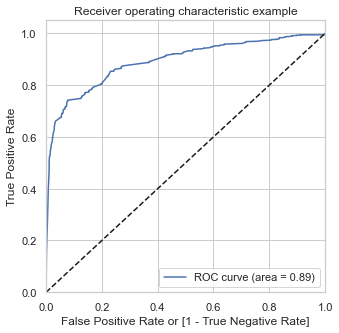

In [237]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_upload, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

In [238]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.165643,10518,0,1,1,0,0,0,0,0,0,0,0
1,0,0.029548,10821,0,1,0,0,0,0,0,0,0,0,0
2,0,0.020756,4669,0,1,0,0,0,0,0,0,0,0,0
3,0,0.029548,4287,0,1,0,0,0,0,0,0,0,0,0
4,0,0.015336,8162,0,1,0,0,0,0,0,0,0,0,0


In [239]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.074428  1.000000  0.000000
0.1   0.1  0.853916  0.769655  0.860692
0.2   0.2  0.921055  0.699310  0.938886
0.3   0.3  0.945283  0.626207  0.970941
0.4   0.4  0.952058  0.543448  0.984916
0.5   0.5  0.950313  0.455172  0.990129
0.6   0.6  0.944770  0.339310  0.993456
0.7   0.7  0.936249  0.169655  0.997893
0.8   0.8  0.930192  0.068966  0.999445
0.9   0.9  0.927010  0.019310  1.000000


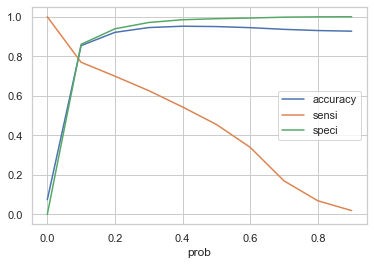

In [240]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [241]:
#### From the curve above, 0.1 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.165643,10518,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.029548,10821,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.020756,4669,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.029548,4287,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.015336,8162,0,1,0,0,0,0,0,0,0,0,0,0


In [242]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,0,0.165643,10518,0,1,1,0,0,0,0,0,0,0,0,0,17
1,0,0.029548,10821,0,1,0,0,0,0,0,0,0,0,0,0,3
2,0,0.020756,4669,0,1,0,0,0,0,0,0,0,0,0,0,2
3,0,0.029548,4287,0,1,0,0,0,0,0,0,0,0,0,0,3
4,0,0.015336,8162,0,1,0,0,0,0,0,0,0,0,0,0,2


In [243]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6993103448275862

In [244]:
# Let us calculate specificity
TN / float(TN+FP)

0.9388864241348713

In [245]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.06111357586512866


In [246]:
# Positive predictive value 
print (TP / float(TP+FP))

0.4792060491493384


In [247]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9748934699988483


In [248]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
confusion

array([[8927,   89],
       [ 395,  330]])

In [249]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.7875894988066826

In [250]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.45517241379310347

In [251]:
y_train_pred_final.photo_upload, y_train_pred_final.predicted

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 9736    0
 9737    0
 9738    0
 9739    0
 9740    0
 Name: photo_upload, Length: 9741, dtype: int64,
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 9736    0
 9737    0
 9738    0
 9739    0
 9740    0
 Name: predicted, Length: 9741, dtype: int64)

In [252]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

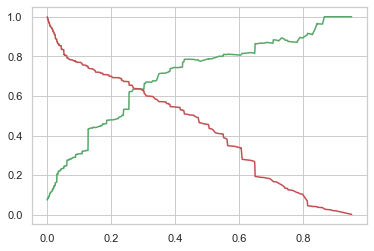

In [253]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [254]:
#Making predictions on the test set

X_test[['distance','duration_photo_upload']] = scaler.fit_transform(X_test[['distance','duration_photo_upload']])

X_train.head()

<ipython-input-254-42eb147c9bee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['distance','duration_photo_upload']] = scaler.fit_transform(X_test[['distance','duration_photo_upload']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
10518,0.124659,1,1,0.996448,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10821,-0.346067,1,0,-0.758573,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4669,-0.648676,1,0,-0.552100,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4287,-0.514183,1,0,-0.758573,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8162,0.528138,0,0,-0.758573,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [255]:
X_test = X_test[col2]
X_test.head()

,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_taboola,lead_medium_affiliate,bundesland_Bremen,bundesland_Hamburg,bundesland_Sachsen
3370,0,0,-0.549670,0,0,0,0,0,0,0
13689,1,0,-0.758440,0,0,0,1,0,0,0
9265,1,0,-0.445285,0,0,0,1,0,0,0
1709,1,1,-0.236516,0,0,0,1,0,0,0
1783,0,0,-0.549670,0,0,0,1,0,0,0


In [256]:
X_test_sm = sm.add_constant(X_test)

In [257]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


3370     0.010680
13689    0.029542
9265     0.017271
1709     0.027804
1783     0.005029
4037     0.123993
1923     0.015332
2841     0.010214
1639     0.469061
2238     0.305634
dtype: float64

In [258]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
3370,0.010680
13689,0.029542
9265,0.017271
1709,0.027804
1783,0.005029


In [259]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_upload,id,0
0,0,3370,0.010680
1,0,13689,0.029542
2,0,9265,0.017271
3,0,1709,0.027804
4,0,1783,0.005029


In [260]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_upload,id,photo_upload_prob
0,0,3370,0.010680
1,0,13689,0.029542
2,0,9265,0.017271
3,0,1709,0.027804
4,0,1783,0.005029


In [261]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_upload,id,photo_upload_prob,final_predicted
0,0,3370,0.010680,0
1,0,13689,0.029542,0
2,0,9265,0.017271,0
3,0,1709,0.027804,0
4,0,1783,0.005029,0


In [262]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_upload, y_pred_final.final_predicted)

0.9331896551724138

In [263]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_upload, y_pred_final.final_predicted )
confusion2

array([[3687,  201],
       [  78,  210]])

In [264]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [265]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7291666666666666

In [266]:
# Let us calculate specificity
TN / float(TN+FP)

0.9483024691358025